In [99]:
from geopy.distance import geodesic
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [9]:
#exclude hawaii and alaska
df = pd.read_csv('capitals.csv', skiprows=[2,9])
#df = pd.read_csv('capitals.csv')

In [85]:
state_to_abv = {}
df_abv = pd.read_csv('state_to_abv.csv')
state_to_abv = {df_abv['State'][i]: df_abv['Abbreviation'][i] for i in range(len(df_abv))}

In [10]:
def generate_random_triplet(n):
    head = np.random.randint(0,n)
    
    left = np.random.randint(0,n)
    while left == head:
        left = np.random.randint(0,n)
        
    right = np.random.randint(0,n)
    while right == left or right == head:
        right = np.random.randint(0,n)
        
    return [head, left, right]

def get_comparison(triplet):
    head = (df['latitude'][triplet[0]], df['longitude'][triplet[0]])
    left = (df['latitude'][triplet[1]], df['longitude'][triplet[1]])
    right = (df['latitude'][triplet[2]], df['longitude'][triplet[2]])
    return geodesic(head, left).miles < geodesic(head, right).miles

def get_true_embedding(df):
    X = np.zeros([len(df),2])
    
    for i in range(len(df)):
        X[i,0] = df['latitude'][i]
        X[i,1] = df['longitude'][i]
    return X

In [134]:
def get_full_data(num_points, df):
    '''
    Generate triplet data
    '''
    # X real embedding
    triplets = []
    labels = []
    for i in range(num_points):
        for j in range(num_points):
            for k in range(num_points):
                if i!=j and i!=k and j!=k:
                    q = [i , j, k]
                    if get_comparison(q):
                        labels.append([0,1])
                    else:
                        labels.append([1,0])
                    triplets.append(q)
    return get_true_embedding(df), {'samples': triplets, 'labels':labels}

def generate_samples(sample_size, triplets, labels, num_points):
    '''
    Generate triplet data
    '''
    random_indices = np.random.choice(int(num_points*(num_points-1)*(num_points-2)/2), sample_size, replace=False)
    return {'samples': [triplets[i] for i in random_indices], 'labels':[labels[i] for i in random_indices]}


def procrustes(X, Y, scaling=True, reflection='best'):
    n = X.shape[0]; m = X.shape[1]
    ny = Y.shape[0]; my = Y.shape[1]
    muX = X.mean(0); muY = Y.mean(0)
    X0 = X - muX; Y0 = Y - muY
    ssX = (X0**2.).sum(); ssY = (Y0**2.).sum()
    normX = np.sqrt(ssX); normY = np.sqrt(ssY)
    X0 /= normX; Y0 /= normY
    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)
    if reflection is not 'best':
        have_reflection = np.linalg.det(T) < 0
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)
    traceTA = s.sum()
    if scaling:
        b = traceTA * normX / normY
        d = 1 - traceTA**2
        Z = normX*traceTA*np.dot(Y0, T) + muX
    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    tform = {'rotation':T, 'scale':b, 'translation':c}
    return d, Z, tform

In [437]:
def find_embedding(X, entire, df, multiplier, sample_size, n, decay_rate, initial_scale, initial_step, batch_size):
    decay = str(decay_rate)
    items = str(n)
    init_scale = str(initial_scale)
    init_step = str(initial_step)

    data = []
    d=2
    # Build the triples
    #X, train, entire = generate_samples(sample_size, n, df)
    train = generate_samples(sample_size, entire['samples'], entire['labels'], n)

    print('num constraints', len(train['samples']))
    train_size = len(train['samples'])

    # Build the Triplet Net
    # W - rows of W will be our learned embedding
    W = tf.Variable(tf.random_normal([n, d], 0., initial_scale), name="weights")
    head = tf.placeholder(tf.float32, [None, n])
    left = tf.placeholder(tf.float32, [None, n])
    right = tf.placeholder(tf.float32, [None, n])
    y = tf.placeholder(tf.float32, [None, 2])

    # Computes |W*e_i - W*e_j|^2
    dleft = tf.pow(tf.norm(tf.subtract(tf.matmul(head,W), tf.matmul(left, W)), axis=1), 2.)
    # Computes |W*e_i - W*e_k|^2
    dright = tf.pow(tf.norm(tf.subtract(tf.matmul(head,W), tf.matmul(right, W)), axis=1), 2.)

    # Hinge loss variant
    p = tf.stack([dleft-dright, dright-dleft], axis=1)

    loss = tf.reduce_mean(tf.maximum(0., 1.-tf.reduce_sum(y*p, reduction_indices=[1])))#tf.losses.hinge_loss(y, p)

    I = np.eye(n,n)
    head_data = [I[q[0], :] for q in train['samples']]
    left_data = [I[q[1], :] for q in train['samples']]
    right_data = [I[q[2], :] for q in train['samples']]
    
    head_data_entire = [I[q[0], :] for q in entire['samples']]
    left_data_entire = [I[q[1], :] for q in entire['samples']]
    right_data_entire = [I[q[2], :] for q in entire['samples']]

    #shuffle the data
    indices = np.random.permutation(train_size)

    # For debugging purposes
    #from tensorflow.python import debug as tf_debug
    sess = tf.InteractiveSession()

    # Setup the optimizer and pass in the loss function/all the data batched in sets of 100 for SGD
    global_step = tf.Variable(1.0, trainable=False)
    learning_rate = tf.train.exponential_decay(initial_step, global_step, len(head_data), decay_rate)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    var_grad = tf.gradients(loss, W)[0]

    # Compute training/test loss
    correct_prediction = tf.equal(tf.argmax(p,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tf.global_variables_initializer().run()

    initials = sess.run([W, loss, y*p, 1.-tf.reduce_sum(y*p, reduction_indices=[1])],feed_dict={head: head_data,
                                                              left: left_data,
                                                              right: right_data,
                                                      y: train['labels']})
    Winitial = initials[0]
    start = time.time()
    iteration = 0
    old_loss = 0
    
    for _ in range(2000):
        print('iter {}'.format(_))
        x = sess.run([accuracy, loss, var_grad, learning_rate],
                              feed_dict={head: head_data,
                                         left: left_data,
                                         right: right_data,
                                         y: train['labels']})

        print('accuracy', x[0], 'loss', x[1], 'gradient', np.linalg.norm(x[2],ord='fro'), 'learning_rate', x[3])

        iteration += 1
        #x[0] == 1 or
        if np.abs(old_loss - x[1]) < .00001:
            break
        old_loss = x[1]

        for i in range(1, int(np.round(train_size/batch_size))):
            if len(head_data[batch_size*(i-1): batch_size*i]) > 0:
                sess.run([train_step],
                          feed_dict={head: [head_data[j] for j in indices[batch_size*(i-1): batch_size*i]],
                                     left: [left_data[j] for j in indices[batch_size*(i-1): batch_size*i]],
                                     right: [right_data[j] for j in indices[batch_size*(i-1): batch_size*i]],
                                     y: [train['labels'][j] for j in indices[batch_size*(i-1): batch_size*i]]})
            else:
                sess.run([train_step],
                          feed_dict={head: [head_data[j] for j in indices[batch_size*(i-1):]],
                                     left: [left_data[j] for j in indices[batch_size*(i-1): ]],
                                     right: [right_data[j] for j in indices[batch_size*(i-1):]],
                                     y: [train['labels'][j] for j in indices[batch_size*(i-1):]]})
        indices = np.random.permutation(train_size)

    result_test = sess.run([accuracy, W, loss,p], feed_dict={head: head_data,
                                                     left: left_data,
                                                     right: right_data,
                                                     y: train['labels']})
    
    result_entire = sess.run([accuracy, W, loss,p], feed_dict={head: head_data_entire,
                                                     left: left_data_entire,
                                                     right: right_data_entire,
                                                     y: entire['labels']})
    end = time.time()
    total_time=(end - start)

    print('Final loss', result_test[2])
    print('Accuracy on train set:', result_test[0])#, result_test[1])
    print('Accuracy on entire data:', result_entire[0])#, result_entire[1])
    min_gap = np.min(np.abs(result_test[3]))
    print('min gap', min_gap)

    #Procrustes and plot
    if d==2:
        W = result_test[1]
        _, Wpro, _ = procrustes(X, W)
        
#         for i in range(len(df)):
#             x = 10*X[i,1]
#             y = 10*X[i,0]
#             plt.plot(x, y, 'bo')
#             plt.text(x * (1 + 0.01), y * (1 + 0.01) , df['name'][i], fontsize=12)
#         plt.show()
#         for i in range(len(df)):
#             x = 10*Wpro[i,1]
#             y = 10*Wpro[i,0]
#             plt.plot(x, y, 'bo')
#             plt.text(x * (1 + 0.01), y * (1 + 0.01) , df['name'][i], fontsize=12)
            
#         plt.show()
        
        frob_error = np.linalg.norm(X-Wpro,'fro')
        print('frob error', frob_error)
        plot_map(Wpro, multiplier, 'map_' + str(multiplier) + '_samples' ,False)
        np.savetxt("Wpro" + str(multiplier), Wpro, delimiter=",")
    return Wpro

In [442]:
def plot_map(X, multiplier, file_name,flag = False):
    move_these_up = ['IN', 'KY', 'VT', 'PA', 'MD', 'NV']
    move_these_right = ['MA', 'RI', 'NJ', 'AL', 'SC']
    # move_these_up = []
    # move_these_right = []
    abvs = state_to_abv.values()

    neg_one = dict((a,-1) if a in move_these_up else (a,1) for a in abvs)
    move_right = dict((a,-.6) if a in move_these_right else (a,1) for a in abvs)
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    plt.axis('off')

    for i in range(len(df)):
        x = X[i,1]
        y = X[i,0]
        plt.plot(x, y, 'bo')
        plt.text(x - move_right[state_to_abv[df['name'][i]]]*2, y  - neg_one[state_to_abv[df['name'][i]]]*1 , df['description'][i] + ', '+ state_to_abv[df['name'][i]], fontsize=15)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    msg = 'Learned embedding using ' + str(multiplier) + '*48*2*log(48) samples'
    if flag:
        msg = 'True map'
#     ax.text(0.05, 0.05, msg , transform=ax.transAxes, fontsize=40,
#         verticalalignment='top', bbox=props)
    
    plt.title(msg, fontsize = 40)
    
    plt.savefig(file_name, format = 'pdf', bbox_inches='tight')
    plt.show()

Run this cell once to get all triplets

In [132]:
X, entire = get_full_data(48, df)

TypeError: get_full_data() missing 1 required positional argument: 'df'

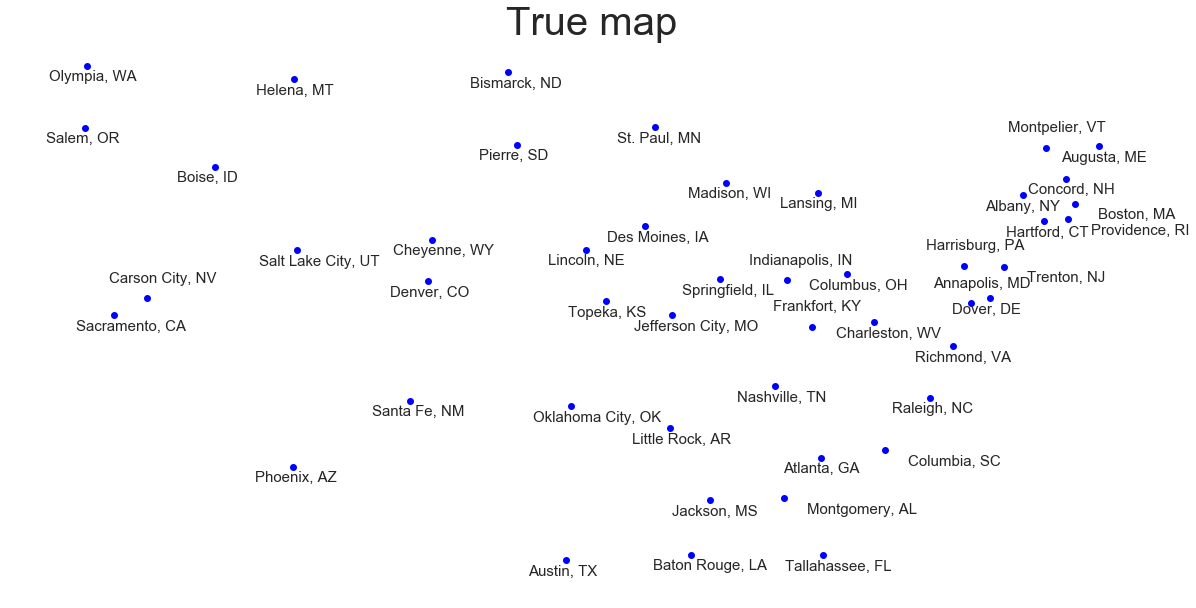

In [407]:
plot_map(X, multiplier, 'true_map',True)

Run the below cell to learn an embedding with $c n d \log(n)$ samples

num constraints 7262
iter 0
accuracy 0.468466 loss 213.134 gradient 6.074e+09 learning_rate 0.899987
iter 1
accuracy 0.804599 loss 3.62188 gradient 1.41421 learning_rate 0.881239
iter 2
accuracy 0.806114 loss 4.64054 gradient nan learning_rate 0.862881


/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/linalg/linalg.py:2176: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)


iter 3
accuracy 0.807766 loss 6.26379 gradient 1.41421 learning_rate 0.844906
iter 4
accuracy 0.800055 loss 9.85197 gradient 6.074e+09 learning_rate 0.827305
iter 5
accuracy 0.828147 loss 5.60218 gradient 1.41421 learning_rate 0.810071
iter 6
accuracy 0.812861 loss 4.73077 gradient 0.0 learning_rate 0.793195
iter 7
accuracy 0.835169 loss 4.48902 gradient 1.41421 learning_rate 0.776672
iter 8
accuracy 0.811898 loss 6.49321 gradient 1.41421 learning_rate 0.760492
iter 9
accuracy 0.835445 loss 5.90577 gradient 6.074e+09 learning_rate 0.74465
iter 10
accuracy 0.84054 loss 7.22219 gradient 0.0 learning_rate 0.729137
iter 11
accuracy 0.810934 loss 8.33384 gradient 0.0 learning_rate 0.713948
iter 12
accuracy 0.859818 loss 5.06705 gradient nan learning_rate 0.699075
iter 13
accuracy 0.819058 loss 6.47091 gradient 3.29272e-10 learning_rate 0.684512
iter 14
accuracy 0.842743 loss 4.92319 gradient 6.074e+09 learning_rate 0.670253
iter 15
accuracy 0.838199 loss 6.17773 gradient nan learning_rate 0

iter 110
accuracy 0.984715 loss 0.154777 gradient 0.0 learning_rate 0.0888263
iter 111
accuracy 0.983063 loss 0.173525 gradient 0.0 learning_rate 0.0869759
iter 112
accuracy 0.9832 loss 0.195566 gradient 0.0 learning_rate 0.085164
iter 113
accuracy 0.986092 loss 0.197894 gradient 3.29272e-10 learning_rate 0.0833899
iter 114
accuracy 0.982787 loss 0.215067 gradient 0.0 learning_rate 0.0816527
iter 115
accuracy 0.98623 loss 0.139608 gradient nan learning_rate 0.0799518
iter 116
accuracy 0.985954 loss 0.113634 gradient nan learning_rate 0.0782862
iter 117
accuracy 0.987469 loss 0.137772 gradient 0.0 learning_rate 0.0766554
iter 118
accuracy 0.98499 loss 0.19154 gradient nan learning_rate 0.0750585
iter 119
accuracy 0.988708 loss 0.135097 gradient 0.0 learning_rate 0.0734949
iter 120
accuracy 0.985266 loss 0.16553 gradient nan learning_rate 0.0719639
iter 121
accuracy 0.989535 loss 0.0937674 gradient 0.0 learning_rate 0.0704648
iter 122
accuracy 0.989672 loss 0.0845181 gradient nan learnin

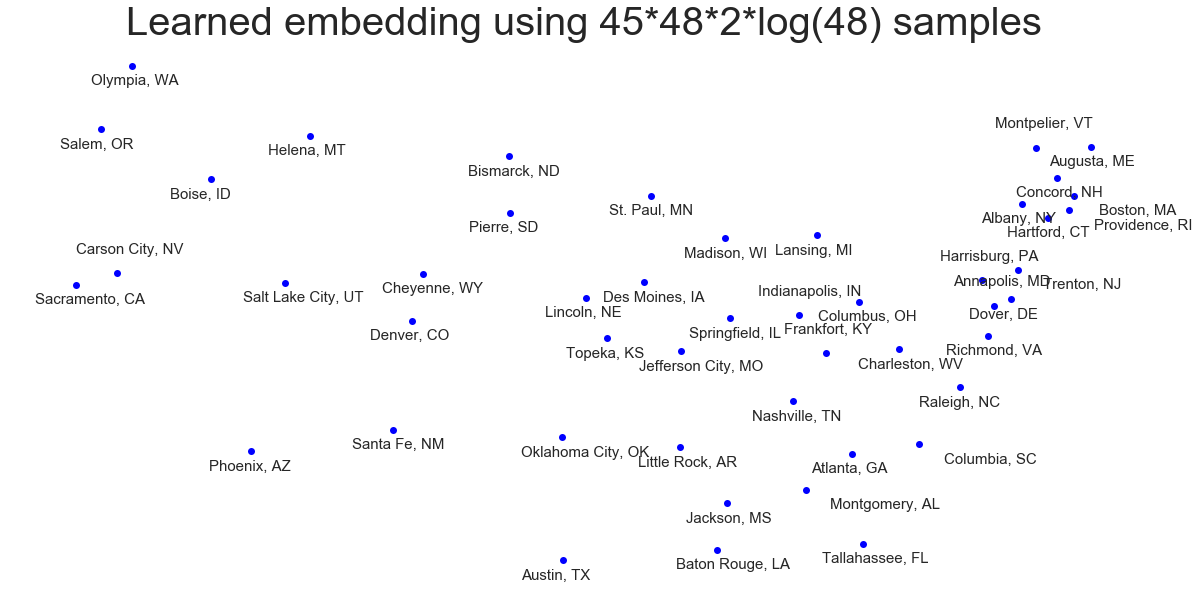

In [444]:
multiplier = 45
sample_size = int(np.floor(multiplier*48*2*np.log10(48)))
#plot_map(W_pro, multiplier, true)
#W_pro = find_embedding(X, entire, df, multiplier,sample_size, 48, .9, 1, .9,2)#, multiplier = 5, 1, .934, 24.75 fro
#W_pro = find_embedding(X, entire, df, multiplier,sample_size, 48, .9, 1, .9,2)#, multiplier = 7, 1, 95.8, 23 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 3)#, multiplier = 9, 1, 96, 21.2 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 3)#, multiplier = 10, 1, .971, 18.2 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 3)#, multiplier = 11, 1, 96.9, 20.9 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 3)#, multiplier = 15 1, .97, 16.3 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 5)#, multiplier = 20, 1, .987, 13.69 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 5)#, multiplier = 25, 1, .987, 15.65 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 5)#, multiplier = 30, 1, .99, 17.74 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 1, .9, 5)#, multiplier = 35, 1, .992, 17.64 fro
#W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 10, .9, 5)#, multiplier = 40, 1, .993, 16.74 fro
W_pro = find_embedding(X, entire, df, multiplier, sample_size, 48, .9, 10, .9, 5)#, multiplier = 40, 1, .993, 16.74 fro